# Hypothesis Testing with Insurance Data (Core)
Nena Esaw

1. State your Null Hypothesis and Alternative Hypothesis
2. Select the correct test according to the data type and number of samples
3. Test the assumptions of your selected test.
4. Execute the selected test, or the alternative test (if you do not meet the assumptions)
5. Interpret your p-value and reject or fail to reject your null hypothesis 
6. Show a supporting visualization that helps display the result

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['insurance - insurance.csv']

### Load Data 

In [2]:
data = 'Data/insurance - insurance.csv'
df = pd.read_csv(data)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Do smokers have higher insurance charges than non-smokers?

#### Use t-test 

 Hypothesis

* Null hypothesis - people that smoke pay more for insurance 
* Alternate - there is no difference in charges for people that smoke and don't smoke 

### Sampling 

In [31]:
#see how many smokers vs non-smokers
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [32]:
smoker = df.loc[df['smoker']== 'yes'].copy()
non_smoker = df.loc[df['smoker']== 'no'].copy()


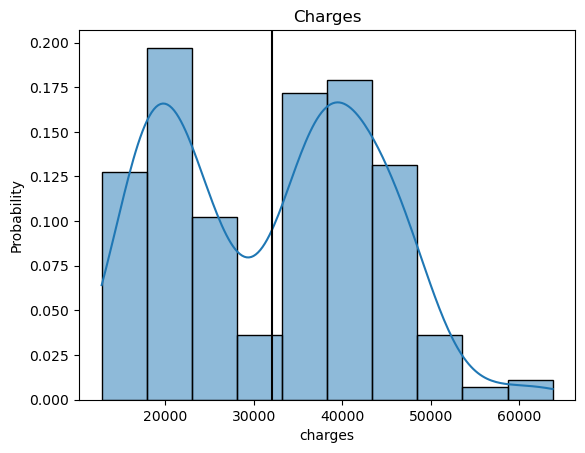

In [33]:
ax = sns.histplot(x=smoker['charges'],stat='probability',kde=True)
ax.axvline(smoker['charges'].mean(), color='k')
ax.set_title("Charges");



In [35]:
result = stats.normaltest(smoker['charges'])
print(result)
# is the p-value less than 0.05?
result.pvalue < .05



NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)


True

* We reject the null hypothesis. There is a significant difference. 

### Are men more likely to smoke than women?

Hypothesis 
* null hypothesis: smokers are determined by sex
* alternate hypothesis: sex does not determine if a person smoke or not

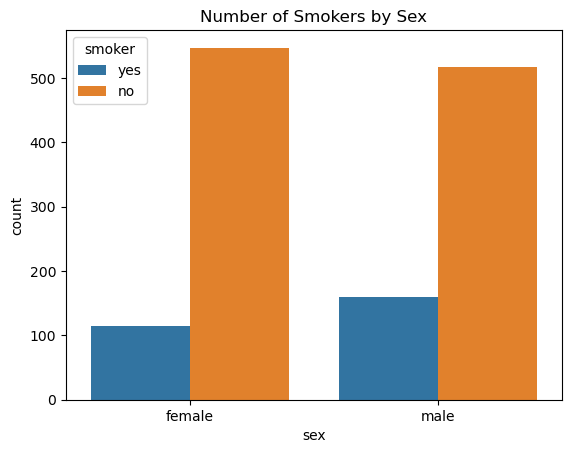

In [36]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");


In [37]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table



smoker,no,yes
sex,,
female,547,115
male,517,159


In [38]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results



In [39]:
# What was our p-value?
print(p)
p<.05



0.006548143503580696


True

* We reject the null hypothesis 

### Do different regions have different charges, on average?

In [18]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

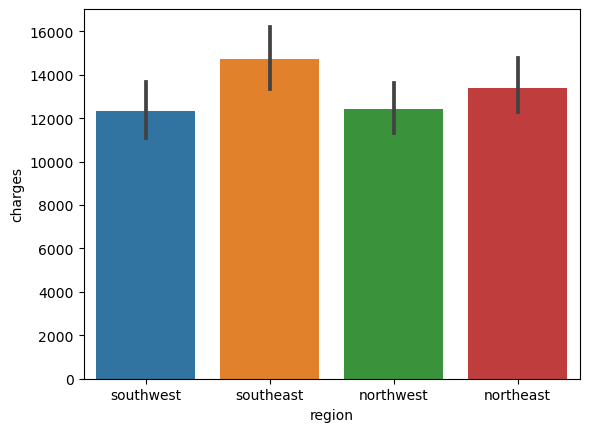

In [20]:
sns.barplot(data=df, x='region',y='charges');

Hypothesis 

* Null hypothesis: Different regions will have the same charges. 
* Alternate hypothesis: Different regions will have different charges. 

### ANOVA Testing 

In [21]:
## Create groups dictionary
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()



dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [22]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [23]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df



,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


#### Testing assumption of equal variance 

In [25]:
# with the * operator 
stats.levene(*groups.values())


LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [26]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result



F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

* Reject the null hypothesis. We have significant differences and will perform pairwise comparisons

#### Tukey's Pairwise comparisons test 

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['charges']
labels = df['region']



In [28]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()



group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


* We can see that there is significant difference between northeast and southeast and northwest and southeast 